# Flood Prediction — v6+ (Stacking + LightGBM/LSTM) — Notebook
*Generated 2025-08-12 12:47*

This notebook mirrors the **v6** workflow (**no calibration, no persistence**) and keeps your **final per‑station thresholds**:

- D08A071 → **0.50**
- D08A084 → **0.533**
- D08A115 → **0.932**

It adds:
- Optional **LightGBM** and **LSTM** base learners (auto-skip if libs missing)
- **Ablation** runs (baseline vs +LightGBM vs +LightGBM+LSTM)
- **LightGBM feature importance** helper
- **Model artifact saving** and a **one-call inference helper**
- Global deterministic seeding + quieter LightGBM logs
- One‑liner **overall Acc/Prec/Rec** after the combined confusion matrix

> Data expected under: `/Users/tree/Projects/hydro-flood-poc/data/raw/station_<CODE>/<CODE>.csv` with columns `saatlik, yagis_toplam, qdeger`.


In [1]:

import warnings, os, joblib, random
import numpy as np
import pandas as pd

from pathlib import Path
from typing import Dict, List, Tuple
from IPython.display import display

warnings.filterwarnings("ignore")

# plotting
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=(8,4)
plt.rcParams["axes.grid"]=True

# sklearn
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.metrics import (
    precision_recall_curve, average_precision_score,
    confusion_matrix, precision_score, recall_score
)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from xgboost import XGBClassifier

# Optional: LightGBM
try:
    import lightgbm as lgb
    HAS_LGBM = True
except Exception:
    HAS_LGBM = False

# Optional: SciKeras + TensorFlow for LSTM
try:
    from scikeras.wrappers import KerasClassifier
    from tensorflow.keras import Sequential
    from tensorflow.keras.layers import Dense, LSTM, Dropout, Input
    from tensorflow.keras.optimizers import Adam
    import tensorflow as tf
    HAS_LSTM = True
except Exception:
    HAS_LSTM = False

print("HAS_LGBM:", HAS_LGBM, "HAS_LSTM:", HAS_LSTM)


HAS_LGBM: True HAS_LSTM: True


In [2]:

SEED = 42

# Global deterministic seeding
np.random.seed(SEED); random.seed(SEED)
try:
    import tensorflow as _tf_seed
    _tf_seed.random.set_seed(SEED)
except Exception:
    pass

DATA_RAW = Path('/Users/tree/Projects/hydro-flood-poc/data/raw')
STATIONS = ['D08A071','D08A084','D08A115']

# Label
PERCENTILE = 0.82   # flood if discharge > station-specific 82nd pct
LEAD_HRS   = 2      # predict 2 hours ahead

# Feature windows
ROLL_RAIN  = [1,3,6,12,24]
LAG_Q      = list(range(1,13))
ROLL_Q_MAX = [3,6,12]
ROLL_Q_MIN = [3,6,12]
ROLL_Q_STD = [3,6,12]
EWMA_RAIN_HALFLIFE = 12

# Final thresholds (nudged)
MY_THR: Dict[str, float] = {'D08A071': 0.50, 'D08A084': 0.533, 'D08A115': 0.932}

# Optional learners (auto-skip if lib missing)
USE_LGBM = True
USE_LSTM = True

# Run ablation variants after each station
RUN_ABLATION = True


In [3]:

def find_csv_for_station(root: Path, code: str) -> Path:
    folder = root / f'station_{code}'
    cands = sorted(folder.glob('*.csv'))
    if not cands:
        raise FileNotFoundError(f'No CSV in {folder}')
    return cands[0]

def load_station(code: str) -> pd.DataFrame:
    csv = find_csv_for_station(DATA_RAW, code)
    df = pd.read_csv(csv)
    df['datetime'] = pd.to_datetime(df['saatlik'])
    df = (df.rename(columns={'yagis_toplam':'rain_mm','qdeger':'discharge_cms'})
            .set_index('datetime').sort_index())
    # hourly regularization
    df = df.resample('h').agg({'rain_mm':'sum','discharge_cms':'mean'})
    return df[~df.index.duplicated(keep='first')]

def add_seasonal_features(idx: pd.DatetimeIndex) -> pd.DataFrame:
    hour = idx.hour.values; doy = idx.dayofyear.values
    feat = pd.DataFrame(index=idx)
    feat['hour_sin'] = np.sin(2*np.pi*hour/24)
    feat['hour_cos'] = np.cos(2*np.pi*hour/24)
    feat['doy_sin']  = np.sin(2*np.pi*doy/366)
    feat['doy_cos']  = np.cos(2*np.pi*doy/366)
    return feat

def build_features(base: pd.DataFrame):
    df = base.copy()

    # Rainfall features
    for w in ROLL_RAIN:
        df[f'rain_sum_{w}h'] = df['rain_mm'].rolling(w, min_periods=1).sum()
    df['rain_ewm'] = df['rain_mm'].ewm(halflife=EWMA_RAIN_HALFLIFE, adjust=False).mean()

    # Discharge features
    for l in LAG_Q: df[f'dis_lag_{l}h'] = df['discharge_cms'].shift(l)
    df['dis_rate_1h'] = df['discharge_cms'].diff(1)
    df['dis_rate_3h'] = df['discharge_cms'].diff(3)
    for w in ROLL_Q_MAX: df[f'dis_max_{w}h'] = df['discharge_cms'].rolling(w, min_periods=1).max()
    for w in ROLL_Q_MIN: df[f'dis_min_{w}h'] = df['discharge_cms'].rolling(w, min_periods=1).min()
    for w in ROLL_Q_STD: df[f'dis_std_{w}h'] = df['discharge_cms'].rolling(w, min_periods=3).std()

    # Dry-spell
    rain_bool = (df['rain_mm'] > 0).astype(int)
    gaps=[]; c=0
    for v in rain_bool:
        c = 0 if v==1 else c+1
        gaps.append(c)
    df['hrs_since_rain'] = gaps

    # Interactions
    df['rain3xlag1'] = df.get('rain_sum_3h',0)*df.get('dis_lag_1h',0)
    df['rain6xlag3'] = df.get('rain_sum_6h',0)*df.get('dis_lag_3h',0)

    # Seasonality
    df = df.join(add_seasonal_features(df.index))

    # Label: 82nd percentile, predict LEAD_HRS ahead
    thr = df['discharge_cms'].quantile(PERCENTILE)
    y = (df['discharge_cms'] > thr).astype(int).shift(-LEAD_HRS)
    df['flood'] = y

    df = df.dropna()
    feat_cols = [c for c in df.columns if c != 'flood']
    return df[feat_cols], df['flood']


In [4]:

def make_lstm_estimator(n_features: int):
    if not (USE_LSTM and HAS_LSTM):
        return None

    # reshape 2D -> 3D (samples, timesteps=n_features, channels=1)
    def to_seq(X):
        X = np.asarray(X, dtype=np.float32)
        return X.reshape((X.shape[0], X.shape[1], 1))

    def build_model(n_features, units=16, lr=1e-3, drop=0.2):
        # Set TF seed inside worker processes (joblib CV)
        try:
            import tensorflow as tf
            tf.random.set_seed(SEED)
        except Exception:
            pass
        model = Sequential([
            Input(shape=(n_features, 1)),
            LSTM(units),
            Dropout(drop),
            Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy')
        return model

    est = Pipeline([
        ('sc', StandardScaler()),
        ('seq', FunctionTransformer(to_seq, validate=False)),
        ('lstm', KerasClassifier(
            model=build_model,
            model__n_features=n_features,
            model__units=16,
            model__lr=1e-3,
            model__drop=0.2,
            epochs=30, batch_size=256, verbose=0,
            random_state=SEED
        ))
    ])
    return est

def make_base_models(n_pos: int, n_neg: int, n_features: int):
    spw = (n_neg / max(1, n_pos)) if n_pos>0 else 1.0
    models = [
        ('xgb', XGBClassifier(
            n_estimators=500, max_depth=6, learning_rate=0.05,
            subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
            random_state=SEED, tree_method='hist', eval_metric='logloss',
            scale_pos_weight=spw
        )),
        ('rf',  RandomForestClassifier(
            n_estimators=400, max_depth=None, min_samples_leaf=2,
            class_weight='balanced', random_state=SEED, n_jobs=-1
        )),
        ('gb',  GradientBoostingClassifier(
            learning_rate=0.05, n_estimators=500, max_depth=3, random_state=SEED
        )),
        ('lr',  LogisticRegression(
            max_iter=2000, class_weight='balanced', solver='lbfgs', random_state=SEED
        )),
        ('mlp', MLPClassifier(
            hidden_layer_sizes=(64,32), activation='relu', alpha=1e-3,
            max_iter=600, random_state=SEED
        )),
    ]
    if USE_LGBM and HAS_LGBM:
        models.append(('lgbm', lgb.LGBMClassifier(
            n_estimators=600, learning_rate=0.05, max_depth=-1,
            subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
            class_weight='balanced', random_state=SEED, n_jobs=-1, verbosity=-1
        )))
    lstm_est = make_lstm_estimator(n_features)
    if lstm_est is not None:
        models.append(('lstm', lstm_est))
    return models

def make_stacker(base_models):
    meta = LogisticRegression(max_iter=3000, class_weight='balanced', solver='lbfgs', random_state=SEED)
    cv = KFold(n_splits=5, shuffle=True, random_state=SEED)  # deterministic
    has_lstm = any(name=='lstm' for name,_ in base_models)
    return StackingClassifier(
        estimators=base_models,
        final_estimator=meta,
        stack_method='predict_proba',
        passthrough=True,
        cv=cv, n_jobs=(1 if has_lstm else -1)  # avoid TF issues in workers
    )

def evaluate_at_threshold(y_true, y_prob, thr):
    y_hat = (y_prob >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_hat, labels=[0,1]).ravel()
    acc = (tp+tn)/(tp+tn+fp+fn)
    prec = precision_score(y_true, y_hat, zero_division=0)
    rec  = recall_score(y_true, y_hat)
    ap   = average_precision_score(y_true, y_prob)
    return dict(threshold=float(thr), acc=acc, precision=prec, recall=rec, ap=ap,
                tn=int(tn), fp=int(fp), fn=int(fn), tp=int(tp))


In [5]:

def run_stack_variants(X_train, X_test, y_train, y_test, thr, n_features):
    variants = {
        "baseline":      dict(use_lgbm=False, use_lstm=False),
        "baseline+LGBM": dict(use_lgbm=True,  use_lstm=False),
        "all":           dict(use_lgbm=True,  use_lstm=True),
    }
    out = {}
    for tag, flags in variants.items():
        bm = make_base_models(int(y_train.sum()), int((y_train==0).sum()), n_features=n_features)
        keep = []
        for name, est in bm:
            if name=='lgbm' and not (flags['use_lgbm'] and HAS_LGBM): continue
            if name=='lstm' and not (flags['use_lstm'] and HAS_LSTM): continue
            keep.append((name, est))
        stk = make_stacker(keep)
        pre = ColumnTransformer([('sc', StandardScaler(), X_train.columns.tolist())], remainder='drop')
        model = Pipeline([('pre', pre), ('model', stk)])
        model.fit(X_train, y_train)
        probs = model.predict_proba(X_test)[:,1]
        mets = evaluate_at_threshold(y_test.values, probs, thr)
        cm = confusion_matrix(y_test, (probs>=thr).astype(int), labels=[0,1])
        out[tag] = (mets, cm)
    return out

def train_eval_all(plot_pr: bool = True) -> pd.DataFrame:
    results = []
    all_cm  = np.zeros((2,2), dtype=int)

    for code in STATIONS:
        print(f"\n=== Station {code} ===")
        base = load_station(code)
        X, y = build_features(base)

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.30, random_state=SEED, stratify=y
        )

        num_cols = X.columns.tolist()
        pre  = ColumnTransformer([('sc', StandardScaler(), num_cols)], remainder='drop')
        base_models = make_base_models(int(y_train.sum()), int((y_train==0).sum()), n_features=X.shape[1])
        stack = make_stacker(base_models)
        pipe = Pipeline([('pre', pre), ('model', stack)])
        pipe.fit(X_train, y_train)

        # Inspect stack contents
        stk = pipe.named_steps['model']
        print("Base learners:", [name for name, _ in stk.estimators])
        print("Final estimator:", type(stk.final_estimator_).__name__)

        # Probabilities
        y_prob = pipe.predict_proba(X_test)[:,1]
        ap = average_precision_score(y_test, y_prob)

        # Fixed threshold (locked values)
        thr = MY_THR.get(code, 0.50)
        m   = evaluate_at_threshold(y_test.values, y_prob, thr)

        # PR curve snapshot
        if plot_pr:
            P, R, T = precision_recall_curve(y_test, y_prob)
            plt.figure()
            plt.plot(R, P, label=f'AP={ap:.3f}')
            plt.scatter([m['recall']], [m['precision']], s=40, marker='x', label=f'thr={thr:.3f}')
            plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title(f'PR curve — {code}')
            plt.legend(); plt.tight_layout(); plt.show()

        print(f"AP={ap:.3f}  Acc={m['acc']:.3f}  Prec={m['precision']:.3f}  Rec={m['recall']:.3f}")
        print(f"CM:\n[[{m['tn']:5d} {m['fp']:5d}]\n [{m['fn']:5d} {m['tp']:5d}]]")

        # optional ablation
        if RUN_ABLATION:
            res = run_stack_variants(X_train, X_test, y_train, y_test, thr, X.shape[1])
            for k,(mm, cm_) in res.items():
                print(f"Ablation[{code} | {k}]: Acc={mm['acc']:.3f} Prec={mm['precision']:.3f} Rec={mm['recall']:.3f} | CM={cm_.tolist()}")

        results.append((code, thr, m))
        all_cm += confusion_matrix(y_test, (y_prob>=thr).astype(int), labels=[0,1])

    print("\n=== Per-station (fixed thresholds) ===")
    for code, thr, m in results:
        print(f"{code}: thr={thr:.3f}  Acc={m['acc']:.3f}  Prec={m['precision']:.3f}  Rec={m['recall']:.3f}  TN={m['tn']} FP={m['fp']} FN={m['fn']} TP={m['tp']}")

    print("\n=== Combined CM (fixed thresholds) ===")
    print(all_cm)
    # overall one-liner
    _tn,_fp,_fn,_tp = all_cm.ravel()
    _overall_acc = (_tn+_tp)/(_tn+_tp+_fp+_fn)
    _overall_prec = (_tp/(_tp+_fp)) if (_tp+_fp)>0 else 0.0
    _overall_rec  = (_tp/(_tp+_fn)) if (_tp+_fn)>0 else 0.0
    print(f"Overall: Acc={_overall_acc:.3f}  Prec={_overall_prec:.3f}  Rec={_overall_rec:.3f}")

    # export
    rows=[]    
    for code, thr, m in results:
        row={"station":code, "threshold":float(thr)}
        row.update({k:v for k,v in m.items() if k!="threshold"})
        rows.append(row)
    df_out=pd.DataFrame(rows).sort_values('station')
    df_out.to_csv('stacking_v6_plus_station_metrics.csv', index=False)
    print('Saved stacking_v6_plus_station_metrics.csv')
    return df_out


In [6]:

def lgbm_feature_importance_station(code):
    if not HAS_LGBM:
        print("LightGBM not installed; skipping.")
        return
    base = load_station(code)
    X, y = build_features(base)
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.30, random_state=SEED, stratify=y)
    clf = lgb.LGBMClassifier(
        n_estimators=800, learning_rate=0.03, num_leaves=63,
        subsample=0.9, colsample_bytree=0.9, class_weight='balanced',
        random_state=SEED, n_jobs=-1, verbosity=-1
    )
    clf.fit(X_tr, y_tr)
    imp = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
    display(imp.head(20))
    outp = f"lgbm_feature_importance_{code}.csv"
    imp.to_csv(outp)
    print("Saved importance:", outp)

os.makedirs("artifacts", exist_ok=True)

def fit_and_save_station(code):
    base = load_station(code)
    X, y = build_features(base)
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.30, random_state=SEED, stratify=y)
    pre  = ColumnTransformer([('sc', StandardScaler(), X.columns.tolist())], remainder='drop')
    bm   = make_base_models(int(y_tr.sum()), int((y_tr==0).sum()), n_features=X.shape[1])
    stk  = make_stacker(bm)
    pipe = Pipeline([('pre', pre), ('model', stk)])
    pipe.fit(X_tr, y_tr)
    path = f"artifacts/stack_v6plus_{code}.joblib"
    joblib.dump(pipe, path)
    print("Saved", path)
    return path

def predict_station_next_hours(code, df_hourly, threshold=None):
    """df_hourly columns: ['saatlik','yagis_toplam','qdeger'].
Returns last 24 rows with probabilities and predictions."""
    model = joblib.load(f"artifacts/stack_v6plus_{code}.joblib")
    df = df_hourly.rename(columns={'saatlik':'datetime','yagis_toplam':'rain_mm','qdeger':'discharge_cms'})
    df['datetime'] = pd.to_datetime(df['datetime'])
    base = (df.set_index('datetime').sort_index()
              .resample('h').agg({'rain_mm':'sum','discharge_cms':'mean'}))
    X, _ = build_features(base)
    probs = model.predict_proba(X)[:,1]
    thr = threshold if threshold is not None else MY_THR.get(code, 0.5)
    preds = (probs >= thr).astype(int)
    out = X.copy()
    out['proba'] = probs
    out['pred']  = preds
    return out.tail(24)



=== Station D08A071 ===


2025-08-12 15:58:50.713412: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-08-12 15:58:50.713675: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-08-12 15:58:50.713688: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-08-12 15:58:50.713936: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-08-12 15:58:50.713950: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-08-12 15:58:51.280572: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Base learners: ['xgb', 'rf', 'gb', 'lr', 'mlp', 'lgbm', 'lstm']
Final estimator: LogisticRegression


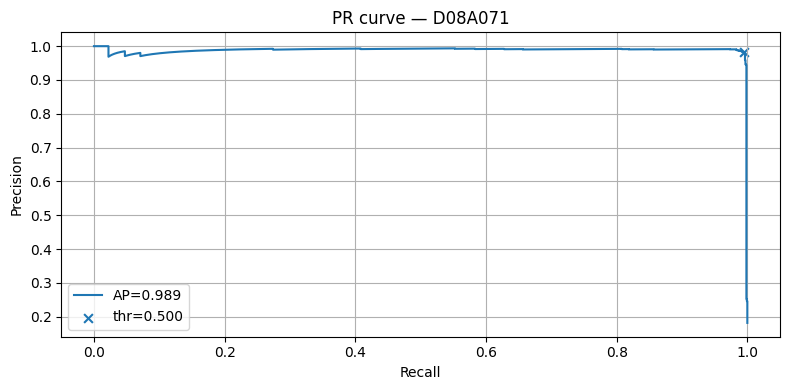

AP=0.989  Acc=0.996  Prec=0.982  Rec=0.994
CM:
[[ 6246    25]
 [    8  1386]]
Ablation[D08A071 | baseline]: Acc=0.996 Prec=0.983 Rec=0.994 | CM=[[6247, 24], [9, 1385]]
Ablation[D08A071 | baseline+LGBM]: Acc=0.996 Prec=0.983 Rec=0.994 | CM=[[6247, 24], [8, 1386]]
Ablation[D08A071 | all]: Acc=0.996 Prec=0.982 Rec=0.994 | CM=[[6246, 25], [8, 1386]]

=== Station D08A084 ===
Base learners: ['xgb', 'rf', 'gb', 'lr', 'mlp', 'lgbm', 'lstm']
Final estimator: LogisticRegression


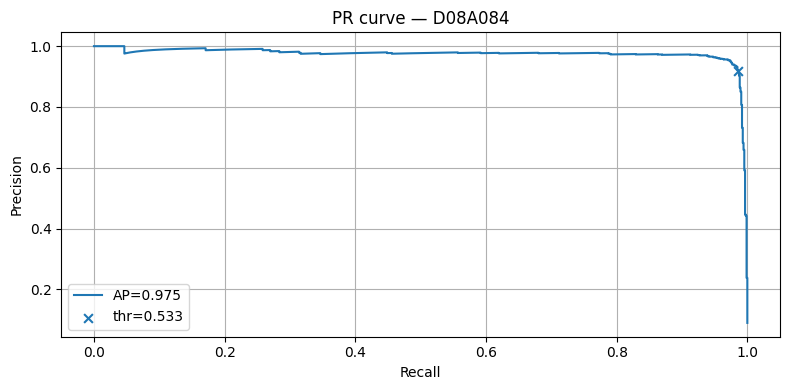

AP=0.975  Acc=0.991  Prec=0.919  Rec=0.986
CM:
[[ 8655    75]
 [   12   848]]
Ablation[D08A084 | baseline]: Acc=0.991 Prec=0.918 Rec=0.985 | CM=[[8654, 76], [13, 847]]
Ablation[D08A084 | baseline+LGBM]: Acc=0.991 Prec=0.919 Rec=0.985 | CM=[[8655, 75], [13, 847]]
Ablation[D08A084 | all]: Acc=0.991 Prec=0.919 Rec=0.986 | CM=[[8655, 75], [12, 848]]

=== Station D08A115 ===
Base learners: ['xgb', 'rf', 'gb', 'lr', 'mlp', 'lgbm', 'lstm']
Final estimator: LogisticRegression


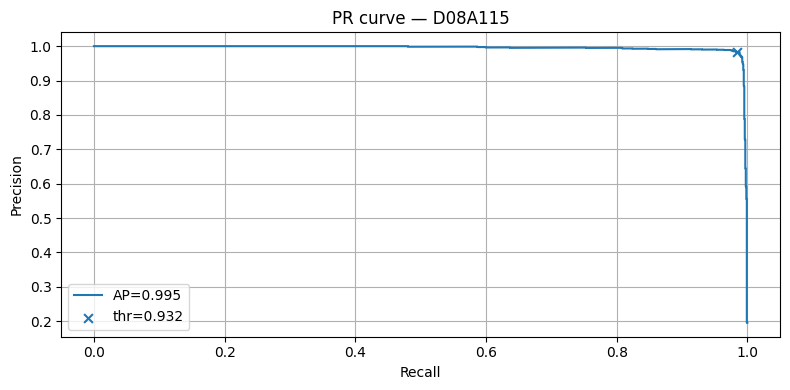

AP=0.995  Acc=0.994  Prec=0.984  Rec=0.984
CM:
[[ 5275    21]
 [   21  1265]]
Ablation[D08A115 | baseline]: Acc=0.993 Prec=0.983 Rec=0.984 | CM=[[5274, 22], [21, 1265]]
Ablation[D08A115 | baseline+LGBM]: Acc=0.994 Prec=0.984 Rec=0.984 | CM=[[5275, 21], [21, 1265]]
Ablation[D08A115 | all]: Acc=0.994 Prec=0.984 Rec=0.984 | CM=[[5275, 21], [21, 1265]]

=== Per-station (fixed thresholds) ===
D08A071: thr=0.500  Acc=0.996  Prec=0.982  Rec=0.994  TN=6246 FP=25 FN=8 TP=1386
D08A084: thr=0.533  Acc=0.991  Prec=0.919  Rec=0.986  TN=8655 FP=75 FN=12 TP=848
D08A115: thr=0.932  Acc=0.994  Prec=0.984  Rec=0.984  TN=5275 FP=21 FN=21 TP=1265

=== Combined CM (fixed thresholds) ===
[[20176   121]
 [   41  3499]]
Overall: Acc=0.993  Prec=0.967  Rec=0.988
Saved stacking_v6_plus_station_metrics.csv


,station,threshold,acc,precision,recall,ap,tn,fp,fn,tp
0,D08A071,0.500,0.995695,0.982282,0.994261,0.988661,6246,25,8,1386
1,D08A084,0.533,0.990928,0.918743,0.986047,0.975033,8655,75,12,848
2,D08A115,0.932,0.993619,0.983670,0.983670,0.994943,5275,21,21,1265


In [7]:

# Run full evaluation (plots PR curves, prints metrics, saves CSV)
df_metrics = train_eval_all(plot_pr=True)
df_metrics
